In [2]:
# Download from https://github.com/facebookresearch/segment-anything
from ultralytics import YOLO
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from glob import glob
import h5py
from multiprocessing import Pool, cpu_count
import os
import cv2
import random

# (Done! No need to run) Predict with YOLO

In [3]:
def read_all_frames(folder):
    frames = []
    for i in range(129):
        image_path = os.path.join(folder, f'{i:03d}.png')
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        frames.append(image)
    return frames

all_frames = read_all_frames("../data")
# From grey to RGB
all_frames = [np.stack([frame, frame, frame], axis=-1) for frame in all_frames]

In [4]:
import cv2
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO("../DL_model/yolov8x-seg.pt")

# # Open the video file
# video_path = "path/to/video.mp4"
# cap = cv2.VideoCapture(video_path)

results = []
# Loop through the video frames
for i in range(129):
    # Read a frame from the video
    
    out = model.track(all_frames[i], persist=True)
    results.append(out)
    # Visualize the results on the frame
    annotated_frame = out[0].plot()

    plt.imshow(annotated_frame)
    plt.title(f"Frame {i:03d}")
    plt.axis("off")
    plt.savefig(f"tracking/{i:03d}.png", bbox_inches='tight', dpi=300)
    plt.close()
    # plt.show()
    # break


0: 384x640 1 person, 4 cars, 1 motorcycle, 1 traffic light, 111.5ms
Speed: 6.9ms preprocess, 111.5ms inference, 745.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 motorcycle, 1 traffic light, 12.8ms
Speed: 1.3ms preprocess, 12.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 2 motorcycles, 3 traffic lights, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 2 motorcycles, 3 traffic lights, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 2 motorcycles, 1 bus, 3 traffic lights, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 2 motorcycles, 1 bus, 2 traffic lights, 14.0ms
Speed: 1.2ms preprocess, 14.0ms inference, 1.1ms postprocess per image at shape (

In [5]:
# Conver all images in tracking/*.png to a video
os.system("ffmpeg -r 10 -i tracking/%03d.png -vcodec mpeg4 -y YOLO_tracking.mp4")

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0

In [24]:
yolo_classes = list(model.names.values())
classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]
colors = [random.choices(range(256), k=3) for _ in classes_ids]

for idx, result in tqdm(enumerate(results)): # 129 images
    if os.path.exists(f"../DL_masks/Yolo_masks_h5_track/{int(idx):03d}.h5"):
        print(f"Skipping {int(result[0][0].path.split('image')[-1].split('.')[0]):03d}.h5")
        continue
    
    segmentations, areas, bboxs, point_coords, cls, ids = [], [], [], [], [], []
    for mask, box in zip(result[0].masks.xy, result[0].boxes):
        
        points = np.int32([mask])
        label = np.full(all_frames[0].shape[0:2], np.nan)
        cv2.fillPoly(label, points, True)
        label = label == 1 # To bool
        
        segmentations.append(label)
        areas.append(label.sum())
        bboxs.append(box.xyxy.cpu().numpy().flatten().astype(int))
        ids.append(box.id.cpu().numpy().flatten().astype(int))
        
        # Centroid of points 
        point_coords.append(np.mean(mask, axis=0))
        cls.append(yolo_classes[classes_ids.index(int(box.cls[0]))])
    
    0
    with h5py.File(f"../DL_masks/Yolo_masks_h5_track/{int(idx):03d}.h5", 'w') as hf:
        hf.create_dataset('segmentations', data=np.array(segmentations), compression="gzip")
        hf.create_dataset('areas', data=np.array(areas), compression="gzip")
        hf.create_dataset('bboxs', data=np.array(bboxs), compression="gzip")
        hf.create_dataset('point_coords', data=np.array(point_coords), compression="gzip")
        hf.create_dataset('cls', data=cls)
        hf.create_dataset('ids', data=np.array(ids), compression="gzip")
        
    # break
    

0it [00:00, ?it/s]

Skipping 000.h5


129it [01:01,  2.10it/s]


# Get object masks

In [25]:
def read_all_frames(folder):
    frames = []
    for i in range(129):
        image_path = os.path.join(folder, f'{i:03d}.png')
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        frames.append(image)
    return frames

all_frames = read_all_frames("../data") ; print(np.array(all_frames).shape)
Yolo_h5_masks = sorted(glob('../DL_masks/Yolo_masks_h5_track/*.h5'))

(129, 2160, 3840)


In [26]:
# Open h5 mask
for idx, h5_mask in enumerate(Yolo_h5_masks):
    try:
        data = h5py.File(h5_mask, 'r')
        name = h5_mask.split('/')[-1].split('.')[0]
        segmentations = data['segmentations']
        id = data['ids']
        # print(data.keys())
        # print(h5_mask, segmentations.shape)
    except Exception as e:
        print(e, h5_mask)
        continue

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'ids', 'point_coords', 'segmentations']>
(7, 2160, 3840)


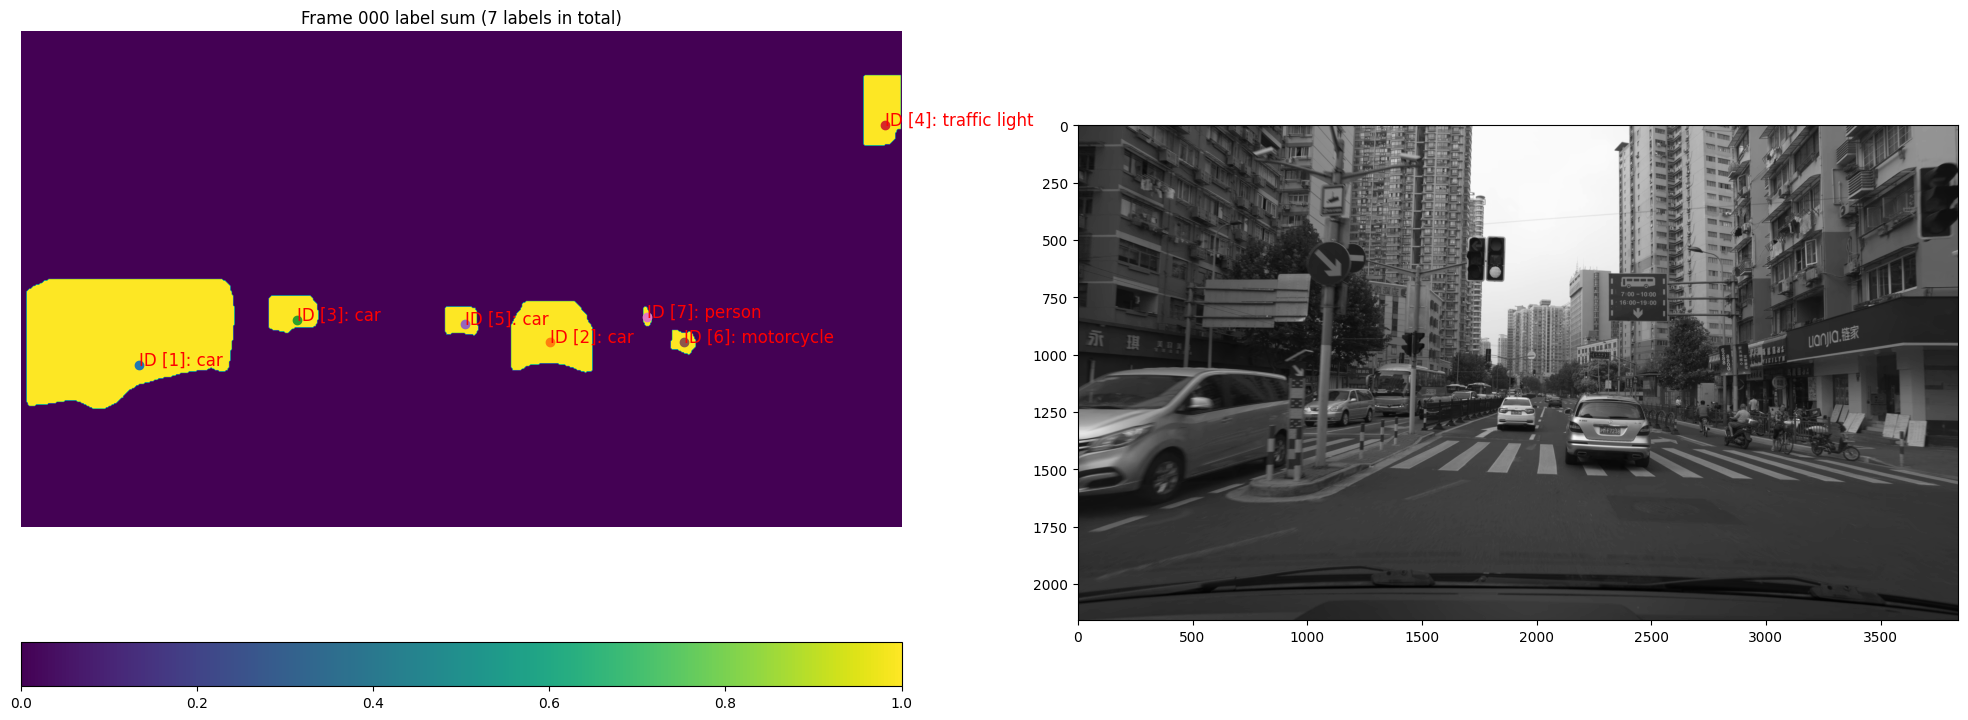

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'ids', 'point_coords', 'segmentations']>
(7, 2160, 3840)


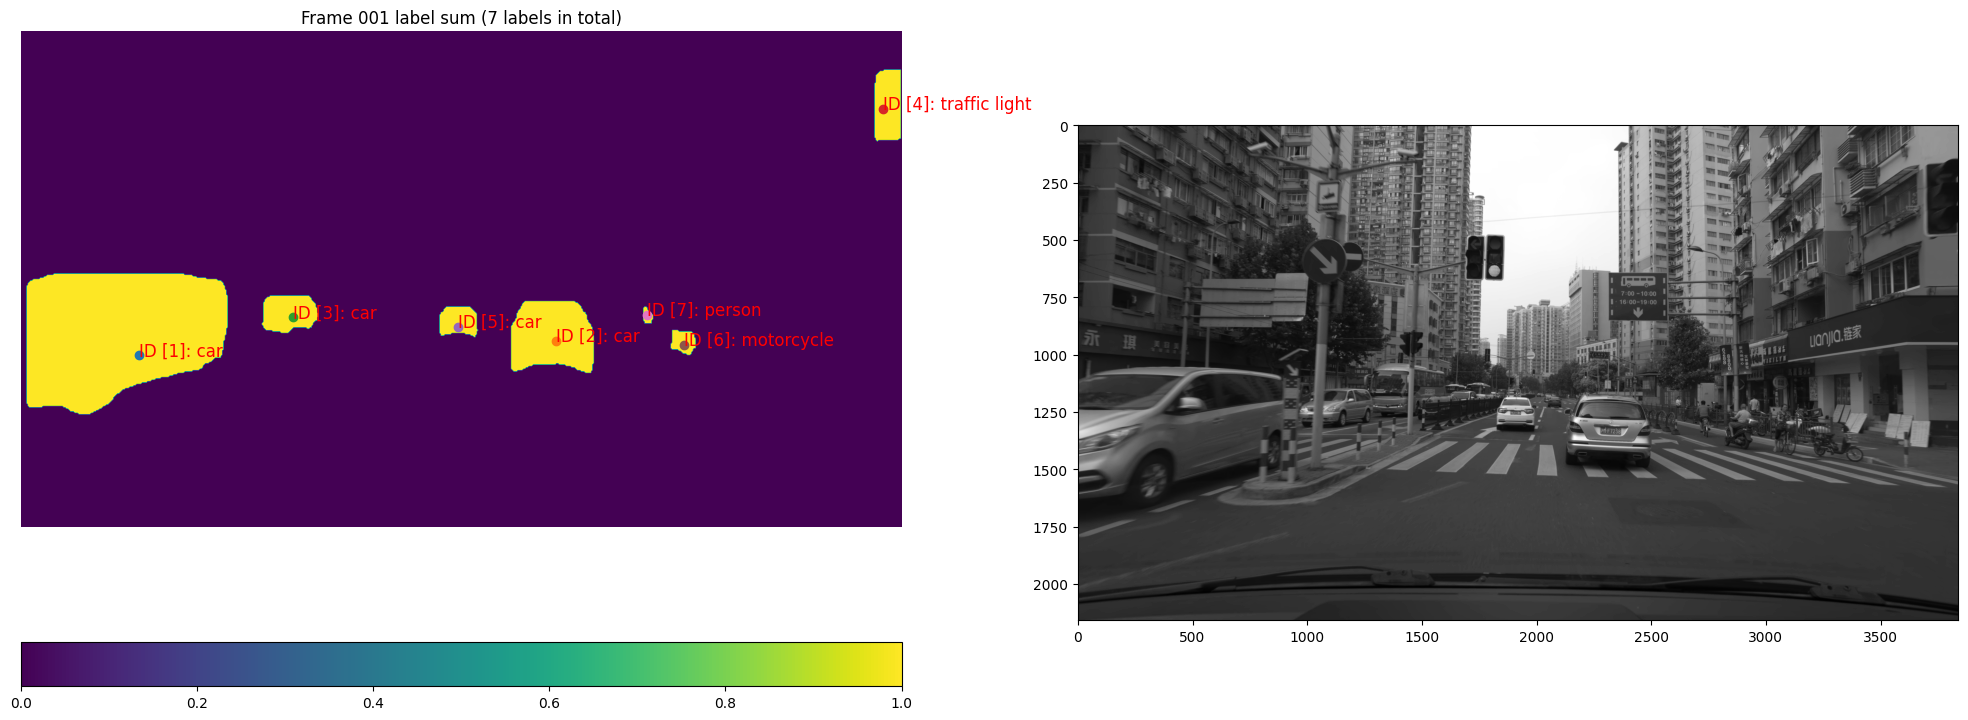

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'ids', 'point_coords', 'segmentations']>
(10, 2160, 3840)


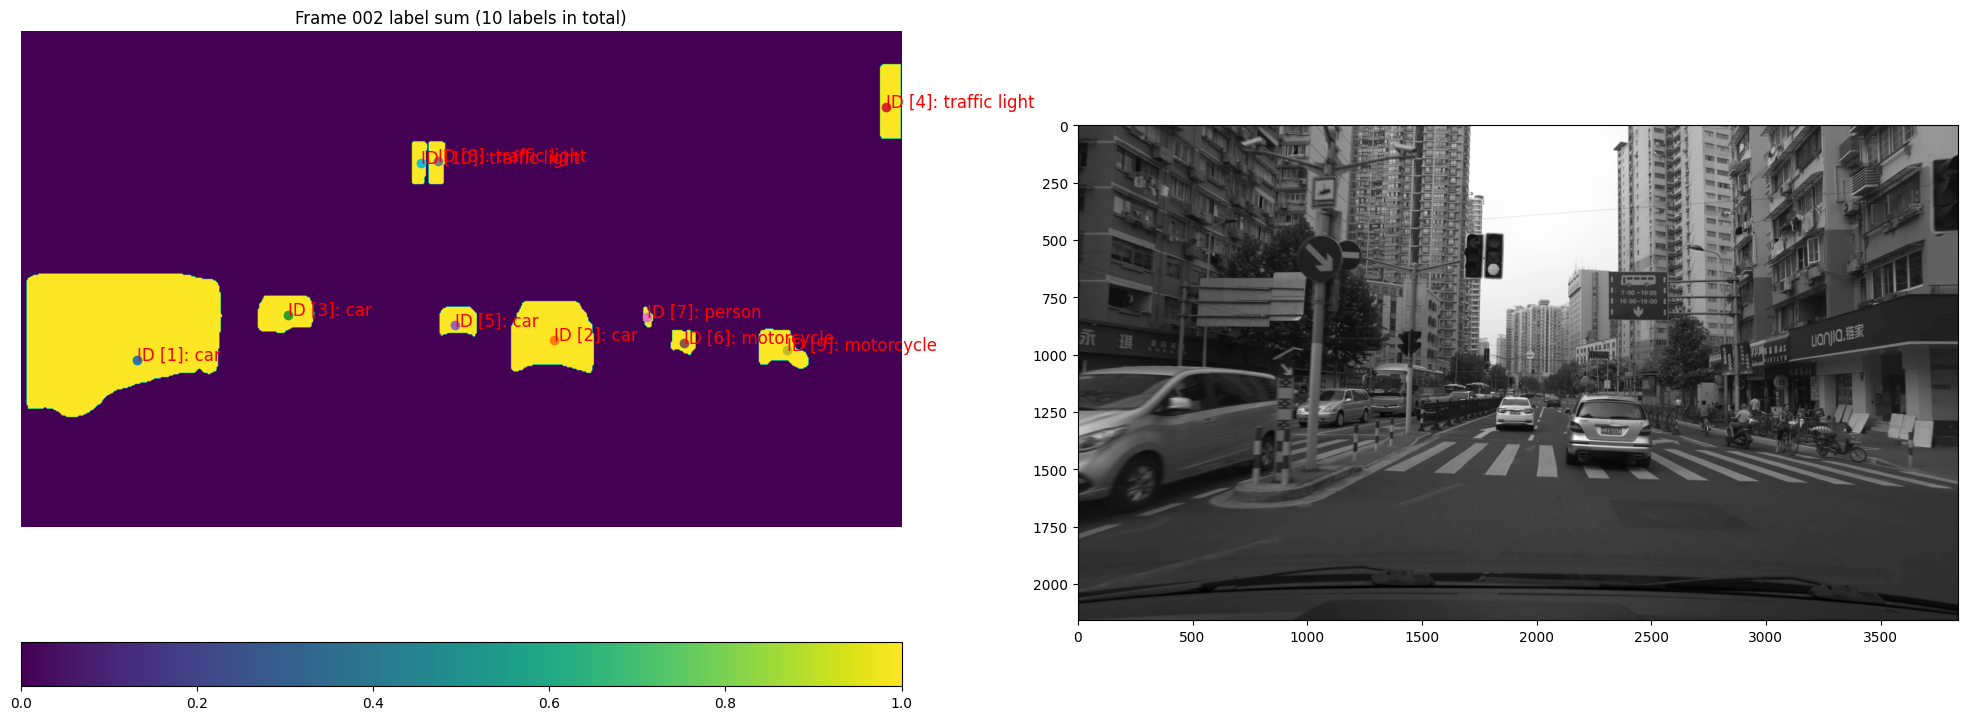

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'ids', 'point_coords', 'segmentations']>
(10, 2160, 3840)


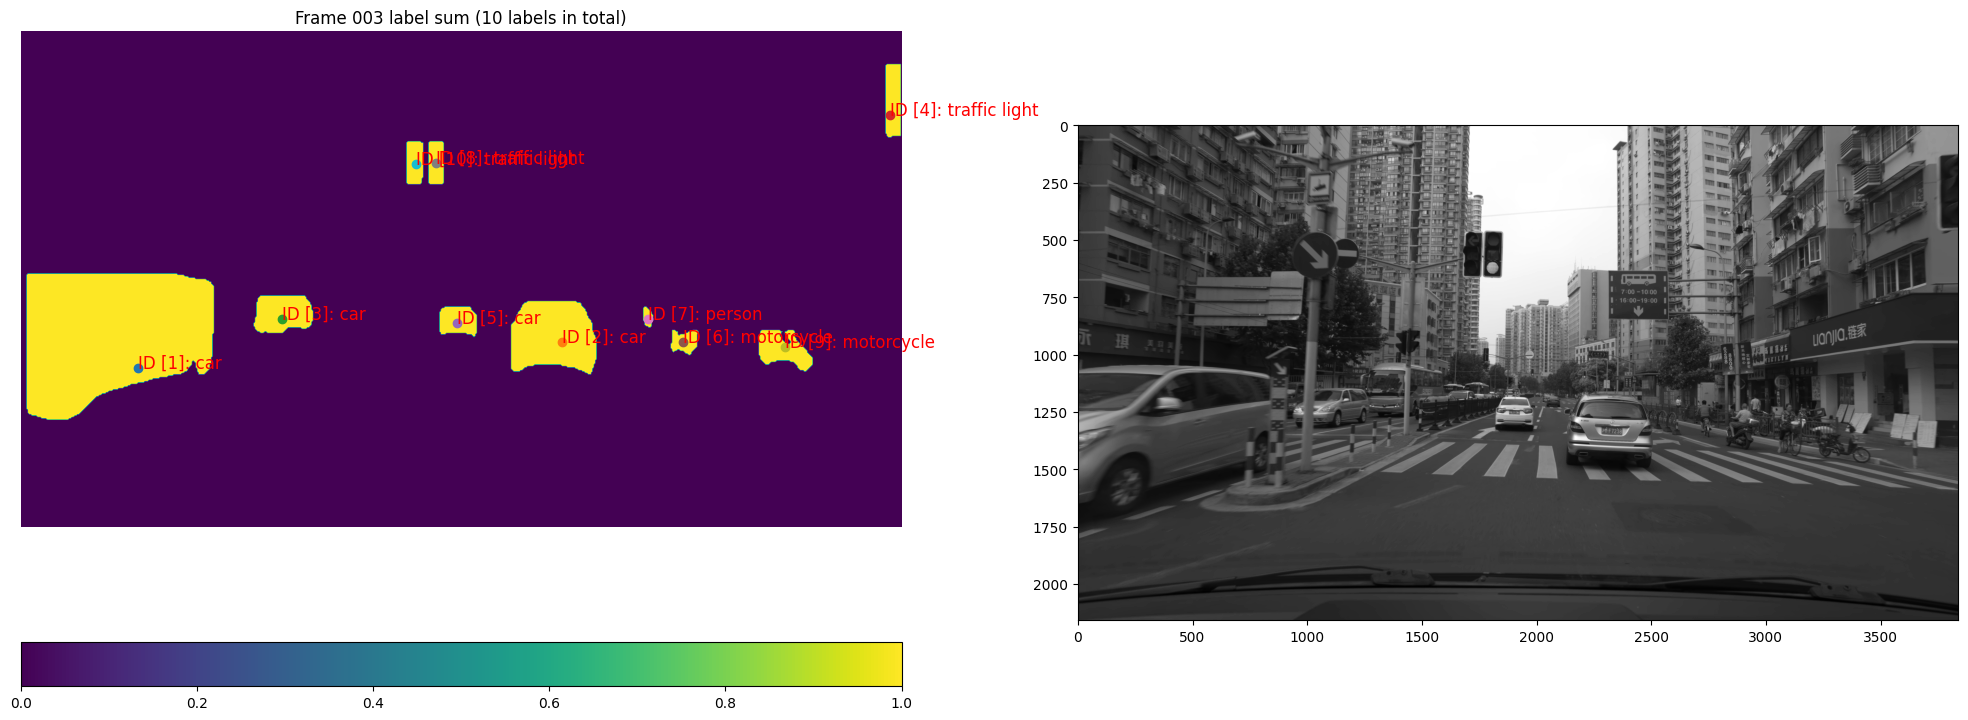

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'ids', 'point_coords', 'segmentations']>
(11, 2160, 3840)


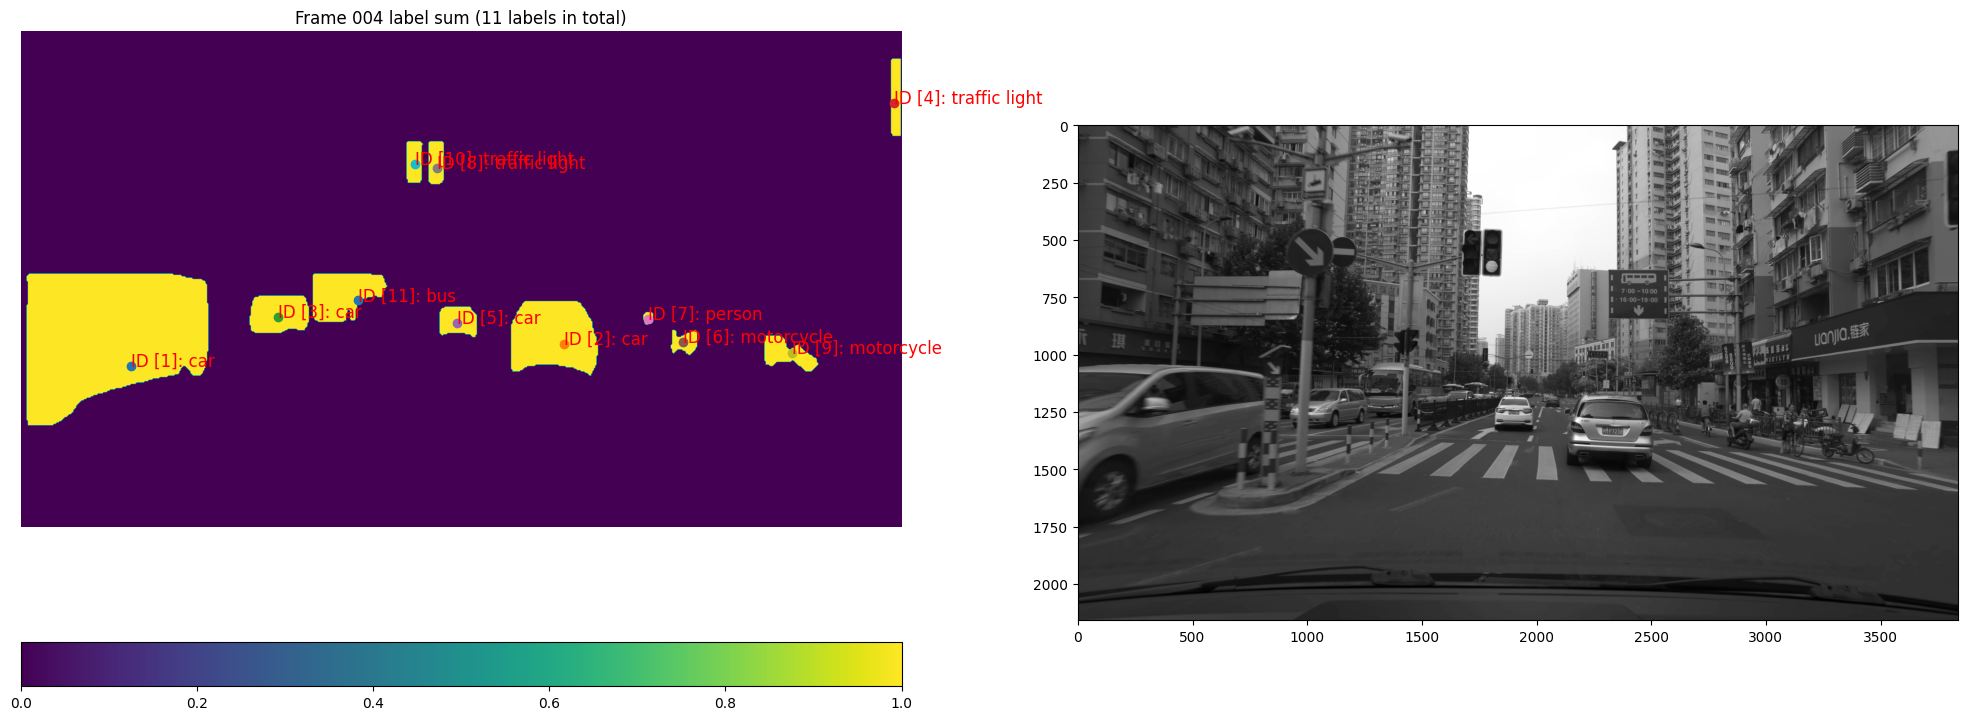

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'ids', 'point_coords', 'segmentations']>
(10, 2160, 3840)


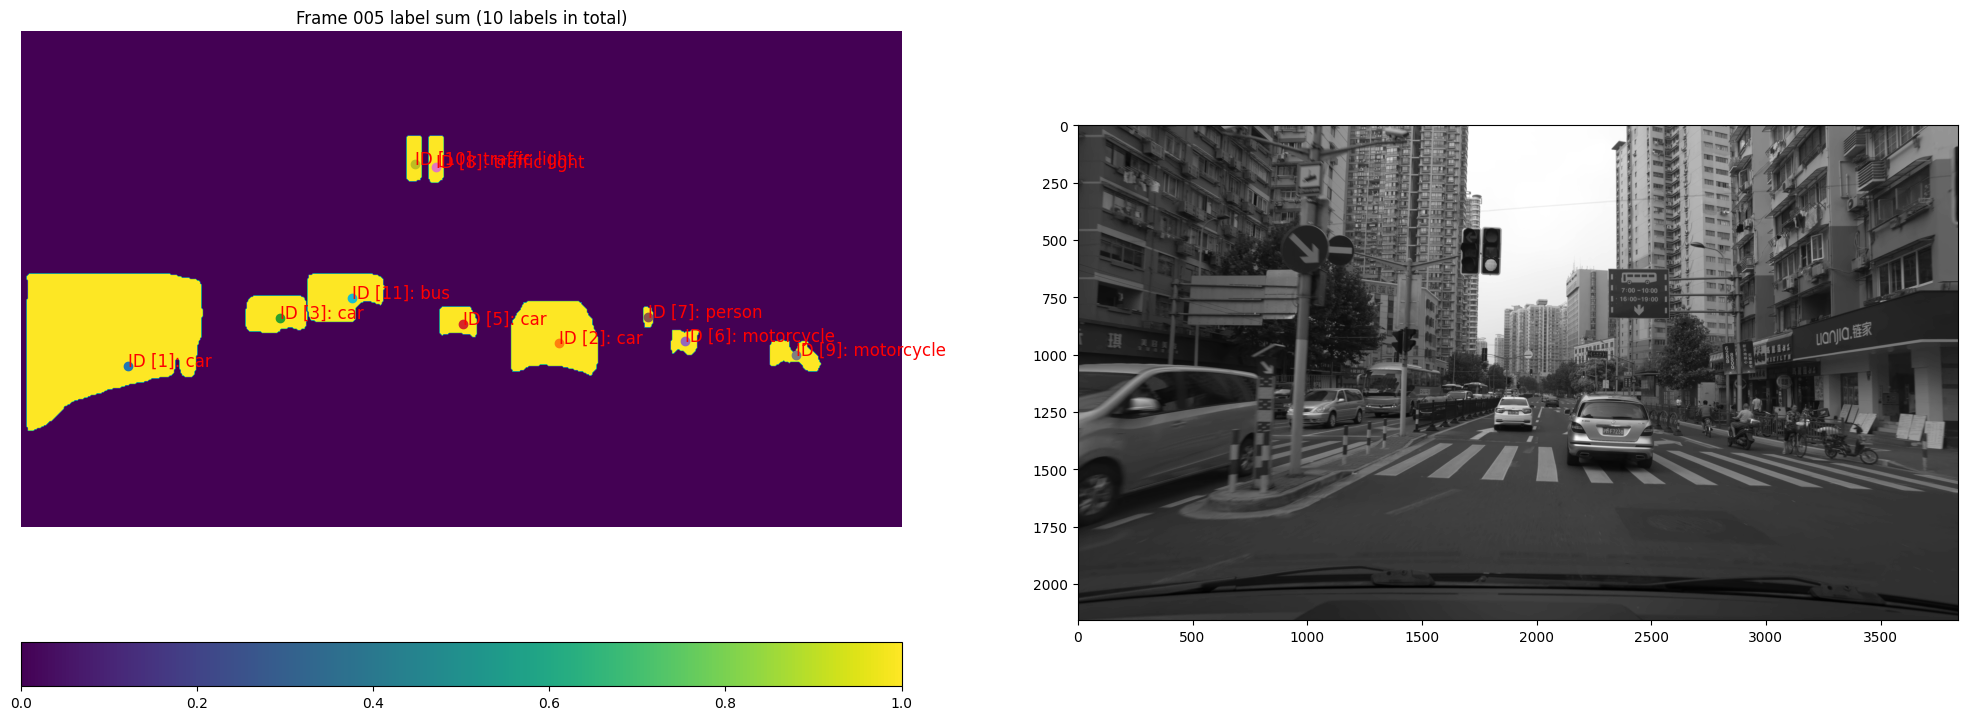

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'ids', 'point_coords', 'segmentations']>
(10, 2160, 3840)


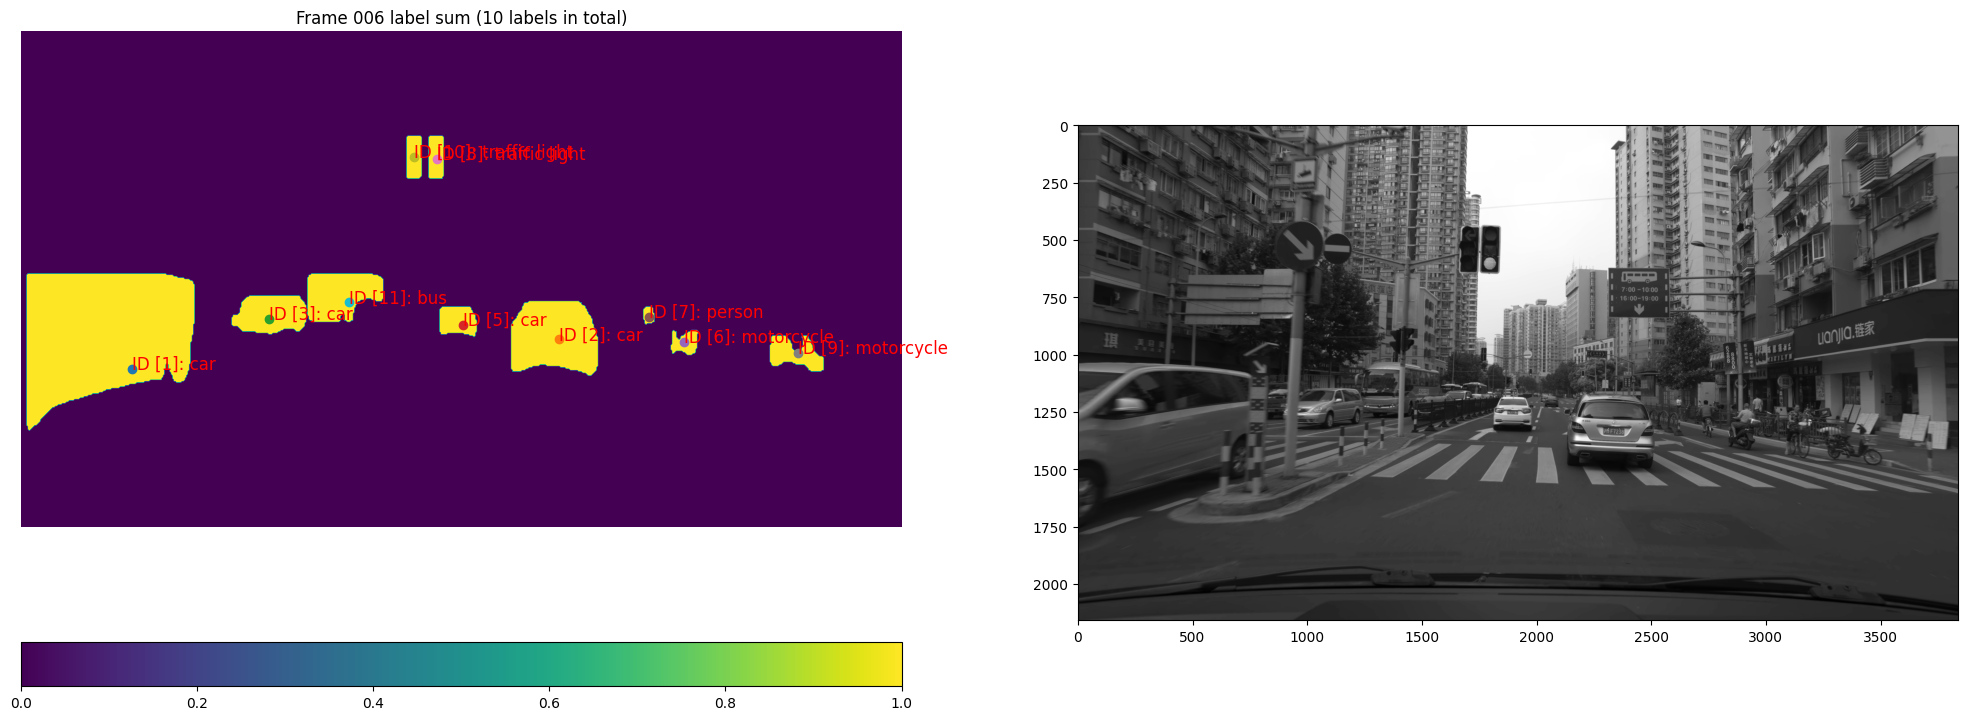

<KeysViewHDF5 ['areas', 'bboxs', 'cls', 'ids', 'point_coords', 'segmentations']>
(10, 2160, 3840)


In [29]:
# Open h5 mask
for idx, h5_mask in enumerate(Yolo_h5_masks):
    data = h5py.File(h5_mask, 'r')
    name = h5_mask.split('/')[-1].split('.')[0]
    print(data.keys())
    segmentations = data['segmentations'][...]
    print(segmentations.shape)
    ids = data['ids'][...]
    
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))
    im_l = ax[0].imshow(segmentations.sum(0))
    plt.colorbar(im_l, ax=ax[0], orientation='horizontal')
    
    point_coords = data["point_coords"]
    cls = data["cls"]
    
    for i, (point, cl) in enumerate(zip(point_coords, cls)):
        ax[0].scatter(point[0], point[1], label=cl)
        ax[0].text(point[0], point[1], f"ID {ids[i]}: {cl.decode('UTF-8')}", fontsize=12, color='red')
    
    ax[0].axis('off')
    ax[0].set_title(f"Frame {name} label sum ({segmentations.shape[0]} labels in total)")
    ax[1].imshow(all_frames[idx], cmap='gray')
    
    plt.show()
    # plt.savefig(f"../DL_masks/Yolo_masks_track/{name}.png")
    # break
    # if idx == 5: break